# 基于kNN的验证码识别

这里的验证码比较简单，只有4位字母或数字。利用kNN就可以得到很好的识别效果。

第一步，需要对图片进行分割。

In [60]:
from PIL import Image
import sys
import os
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
import numpy as np
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu, inverse
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.morphology import disk,square
from skimage.morphology import binary_erosion,binary_opening,binary_closing
from skimage.filters import rank
from skimage.filters import median
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops
from skimage.transform import resize
from skimage import img_as_int

%matplotlib inline

def seg(image):
    pre_image = __preproc(image)
    sub_images = __seg_by_region(pre_image)

    return sub_images


def __preproc(image):
    """ 图片预处理
    """
    # 二值化
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    # 中值滤波
    med = median(binary, disk(1))

    return med

def __seg_by_region(image):
    """ 图片分割
    用skimage中regionprops函数直接分出来的效果就不错，所以就不用自己想办法分了
    """
    lab_img = label(image, connectivity=2, background=255)

    rs = []
    for region in regionprops(lab_img):
        # skip small images
        if region.area < 20:
            continue

        if region.area > 80:
            mid = int(region.image.shape[1] / 2) + 1
            rs.append(1 - resize(region.image[:, 0:mid], (24, 16), mode='constant'))
            rs.append(1 - resize(region.image[:, mid:], (24, 16), mode='constant'))
        else:
            rs.append(1 - resize(region.image, (24, 16), mode='constant'))

    return rs

以下是一个示例：

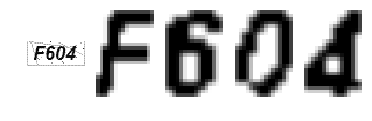

In [61]:
# 读入图片，抛弃RGB
img = imread('input/test/20160819153048.gif', as_grey=True)

# 显示原图
fig, axs = plt.subplots(1, 5)
axs[0].imshow(img, cmap=plt.cm.gray)
axs[0].axis('off')

# 图片分割
sub_imgs = seg(img)

# 显示分割后的图片
i = 1
for si in sub_imgs:
#     print(si)
    axs[i].imshow(si, cmap=plt.cm.gray)
    axs[i].axis('off')
    i += 1

plt.show()

按照上面方式分割一些图片，然后保存每一个单独的字母或数字，并对每个字母、数字进行人工标记。这份工作就不展示了，标记好的数据在./input/train/路径中。

对于新的图片，我们先对它按照上述方法进行分割，然后每一个数字、字母与样本去计算距离。

首先，读入样本数据。

In [51]:
def read_simple():
    """ 读入已经人工标记好的样本数据
    """
    _p = './input/train'

    train_data = {}
    labels = {}

    for _sub_p in os.listdir(_p):
        if (os.path.isdir('%s/%s' % (_p, _sub_p))):
            i = 0
            for _f in os.listdir('%s/%s' % (_p, _sub_p)):
                if _f[-3:] == 'png' and i < 40:
                    image = imread('%s/%s/%s' % (_p, _sub_p, _f), as_grey=True)
                    thresh = threshold_otsu(image)
                    binary = image > thresh
                    train_data['%s_%s' % (_sub_p, _f)] = binary
                    labels['%s_%s' % (_sub_p, _f)] = _sub_p
                    i += 1

    return train_data, labels

train_data, labels = read_simple()

然后对测试数据进行测试。我人工对比了一下，准确率还是很高的。

In [66]:
def distance(image1, image2):
    """ 求两个图片的距离
    """
    diff = image1 - image2
    h, w = diff.shape

    sum = 0.0
    count = 0
    for i in range(h):
        for j in range(w):
            sum += diff[i][j] ** 2
            count += 1
    sum = sum ** 0.5

    return sum/count

def reco(image, train_data, lablels):
    """ 验证码识别
    """
    subs = seg(image)

    i = 0
    rs_code = ''
    
    # 切分成4小块，分别识别
    for sub in subs:
        # 有时候划分会多于4个，只识别4个，肯定是错误的，那也没办法了
        i += 1
        if len(rs_code) > 3:
            break
        
        # 离每一个样本的距离
        rs = {}
        for key in train_data:
            isP = False
            d = distance(sub, train_data[key])
            rs[key] = d
        
        # 按距离排序
        rs = sorted(rs.items(), key=lambda d: d[1])

        # 投票选取比例最高的
        class_count = {}
        for i in range(10):
            voteLabel = lablels[rs[i][0]]
            class_count[voteLabel] = class_count.get(voteLabel, 0) + 1
        sorted_class_count = sorted(class_count.items(),key=lambda d:d[1],reverse=True)

        rs_code = rs_code + sorted_class_count[0][0]
    return rs_code

def reco_by_filename(fn):
    image = imread(fn, as_grey=True)
    rs = reco(image, train_data, labels)
    return rs


_path = './input/test/'
for _fn in os.listdir(_path):
    if os.path.isdir('%s%s' % (_path, _fn)) or _fn[-3:] != 'gif':
        continue
    img = imread('%s%s' % (_path, _fn), as_grey=True)
    rs = reco(img, train_data, labels)
    print('%s: %s' % (_fn, rs))

20160819153048.gif: f604
20160819153849.gif: f6lf
20160819153920.gif: 6428
20160819153942.gif: jb66
20160819153948.gif: d224
20160819154041.gif: 2d64
20160819154046.gif: t8rr
20160819154052.gif: 6b4b
20160819154057.gif: 0pd4
20160819154103.gif: x80v
20160819154115.gif: n6n8
20160819154121.gif: hfd2
20160819154126.gif: hfxj
20160819154132.gif: 2ppt
20160819154317.gif: plhd
20160819154323.gif: 842z
20160819154333.gif: 8t6l
20160819154339.gif: v640
20160819154345.gif: h4zj
20160819154350.gif: t2td
20160819154356.gif: 40l2
20160819154401.gif: 68fr
20160819154408.gif: 066b
20160819154413.gif: 4x42
